# Visualise the CMSSM dataset

Imports and load the dataset.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import numpy as np

h5 = h5py.File('../CMSSM_subset.hdf5', 'r')

lnlike = '#LHC_Combined_LogLike @ColliderBit::calc_LHC_LogLike'

## Basic summary statistics

In [ ]:
from collections import namedtuple

Summary = namedtuple('Summary', ['label', 'min', 'max', 'mean'])
def summary(h5, k):
    d = np.array(h5[k])
    return Summary(label = label(k), min=d.min(), max=d.max(), mean=d.mean())
    print('%s\t%+.2e\t%+.2e\t%+.2e' % (label(k), d.min(), d.max(), d.mean()))

def label(k):
    l = k.split('::')[-1]
    if l == 'calc_LHC_LogLike':
        l = 'lnL'
    return l

summaries = {k : summary(h5, k) for k in h5.keys()}

for _, s in summaries.items():
    print('%s\t%+.2e\t%+.2e\t%+.2e' % (s.label, s.min, s.max, s.mean))

A0	-1.00e+04	+1.00e+04	+1.66e+03
M0	+2.44e+02	+1.00e+04	+7.33e+03
M12	+4.37e+02	+6.14e+03	+2.59e+03
SignMu	-1.00e+00	+1.00e+00	-1.64e-01
TanBeta	+3.90e+00	+5.61e+01	+3.21e+01
lnL	-3.10e+02	+3.09e+00	-8.76e-01


## 1D histograms

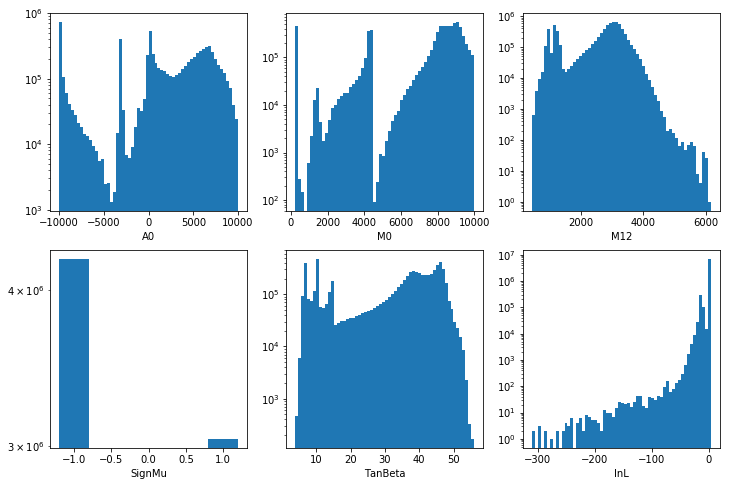

In [ ]:
def bins(var):
    if label(var) == 'SignMu':
        return np.linspace(-1.2, 1.2, 7)
    else:
        s = summaries[var]
        return np.linspace(s.min, s.max, 61)    

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
for k, ax in zip(h5.keys(), axes.flatten()):
    ax.hist(h5[k], bins=bins(k))
    ax.set_xlabel(label(k))
    ax.set_yscale('log')

## 2D Histograms 

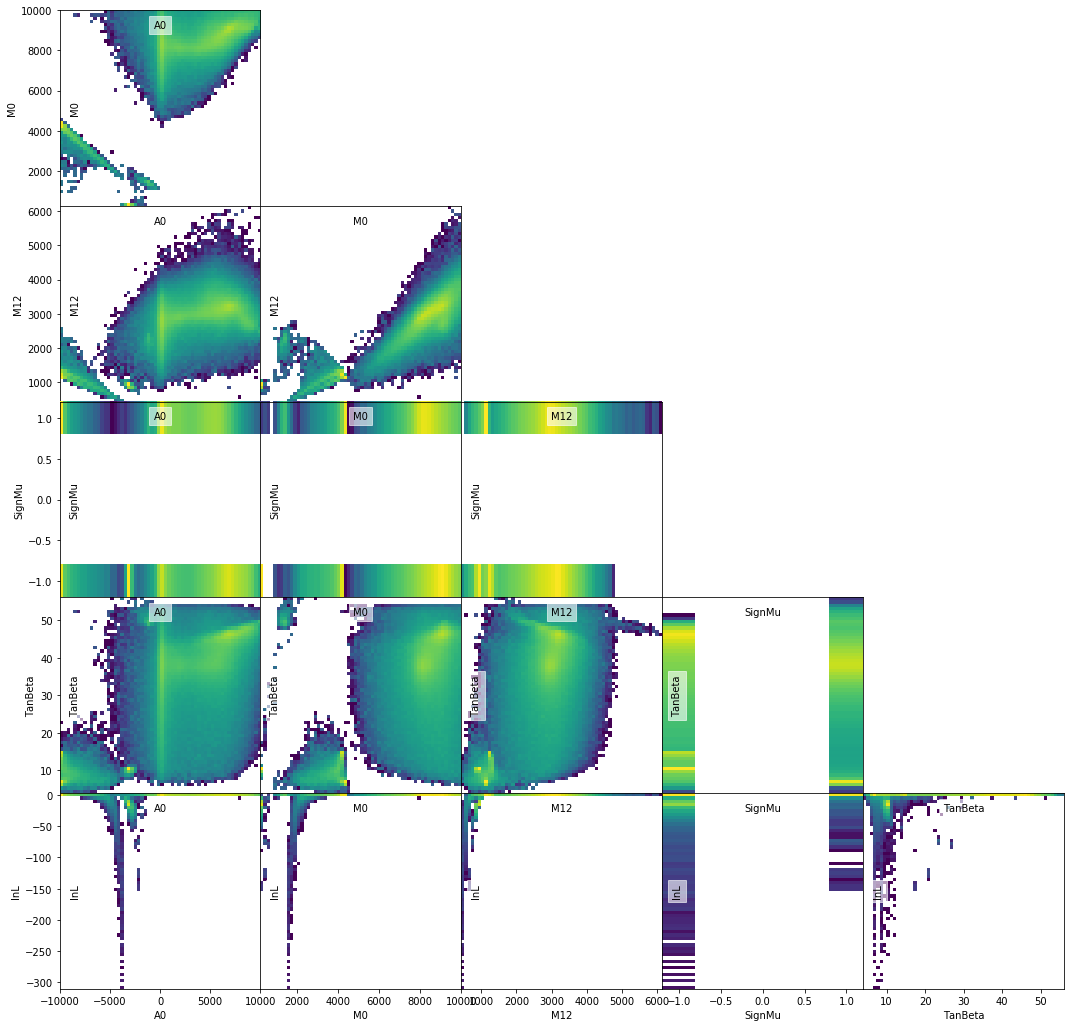

In [ ]:
nvar = 6
fig, axes = plt.subplots(ncols=nvar-1, nrows=nvar-1, figsize=(nvar*3, nvar*3))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for i, x in enumerate(h5.keys()):
    for j, y in enumerate(h5.keys()):
        
        if i == nvar-1 or j == 0:
            continue
        
        ax = axes[j-1,i]

        if i >= j:
            ax.axis('off')
            continue


        ax.hist2d(np.array(h5[x]), np.array(h5[y]),
                  bins=(bins(x), bins(y)),
                  cmap='viridis', norm=LogNorm())
        
        bbox_props = dict(fc='white', ec='white', alpha=0.6)
        ax.text(0.5, 0.95, label(x), transform=ax.transAxes, va='top', ha='center', bbox=bbox_props)
        ax.text(0.05, 0.5, label(y), transform=ax.transAxes, rotation=90, va='center', ha='left', bbox=bbox_props)

        if j == nvar-1:
            ax.set_xlabel(label(x))
        else:
            ax.set_xticks([])
        if i == 0:
            ax.set_ylabel(label(y))
        else:
            ax.set_yticks([])